<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-ResNet-구현하기" data-toc-modified-id="1.-ResNet-구현하기-1">1. ResNet 구현하기</a></span><ul class="toc-item"><li><span><a href="#1)-기본-블록-구성하기" data-toc-modified-id="1)-기본-블록-구성하기-1.1">1) 기본 블록 구성하기</a></span></li><li><span><a href="#2)-ResNet-34" data-toc-modified-id="2)-ResNet-34-1.2">2) ResNet-34</a></span></li><li><span><a href="#3)-ResNet-50" data-toc-modified-id="3)-ResNet-50-1.3">3) ResNet-50</a></span></li></ul></li><li><span><a href="#2.-Plain-Network-만들기" data-toc-modified-id="2.-Plain-Network-만들기-2">2. Plain Network 만들기</a></span><ul class="toc-item"><li><span><a href="#1)-Plain-34" data-toc-modified-id="1)-Plain-34-2.1">1) Plain-34</a></span></li><li><span><a href="#2)-Plain-50" data-toc-modified-id="2)-Plain-50-2.2">2) Plain-50</a></span></li></ul></li><li><span><a href="#3.-데이터셋-준비하기" data-toc-modified-id="3.-데이터셋-준비하기-3">3. 데이터셋 준비하기</a></span><ul class="toc-item"><li><span><a href="#1)-데이터셋-로드" data-toc-modified-id="1)-데이터셋-로드-3.1">1) 데이터셋 로드</a></span></li><li><span><a href="#2)-Input-Normalization" data-toc-modified-id="2)-Input-Normalization-3.2">2) Input Normalization</a></span></li></ul></li><li><span><a href="#4.-ResNet과-Plain-모델-성능-비교" data-toc-modified-id="4.-ResNet과-Plain-모델-성능-비교-4">4. ResNet과 Plain 모델 성능 비교</a></span><ul class="toc-item"><li><span><a href="#1)-모델-학습" data-toc-modified-id="1)-모델-학습-4.1">1) 모델 학습</a></span><ul class="toc-item"><li><span><a href="#ResNet-34" data-toc-modified-id="ResNet-34-4.1.1">ResNet-34</a></span></li><li><span><a href="#ResNet-50" data-toc-modified-id="ResNet-50-4.1.2">ResNet-50</a></span></li><li><span><a href="#Plain-34" data-toc-modified-id="Plain-34-4.1.3">Plain-34</a></span></li><li><span><a href="#Plain-50" data-toc-modified-id="Plain-50-4.1.4">Plain-50</a></span></li></ul></li><li><span><a href="#2)-결과-비교" data-toc-modified-id="2)-결과-비교-4.2">2) 결과 비교</a></span></li></ul></li></ul></div>

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. ResNet 구현하기
## 1) 기본 블록 구성하기

In [3]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [4]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

In [5]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=10, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

## 2) ResNet-34

In [6]:
resnet_34 = build_resnet(input_shape=(32,32,3), is_50=False, name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 16, 16, 64)   0           batch_normalization[0][0]        
__________________________________________________________________________________________

## 3) ResNet-50

In [7]:
resnet_50 = build_resnet(input_shape=(32,32,3), is_50=True)
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 16, 16, 64)   9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 16, 16, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 16, 16, 64)   0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

# 2. Plain Network 만들기

In [8]:
# resnet block에서 shortcut을 제외한 plain block
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [9]:
def build_plainnet(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

## 1) Plain-34

In [10]:
plain_34 = build_plainnet(input_shape=(224,224,3), is_50=False, name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256

## 2) Plain-50

In [11]:
plain_50 = build_plainnet(input_shape=(224,224,3), is_50=True)
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 56, 56, 64)        256

In [12]:
del resnet_34
del resnet_50
del plain_34
del plain_50

# 3. 데이터셋 준비하기
## 1) 데이터셋 로드

In [13]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [14]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


In [15]:
# 데이터 개수 확인
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [16]:
ds_info.features["label"].num_classes

2

In [17]:
ds_info.features["label"].names

['cat', 'dog']

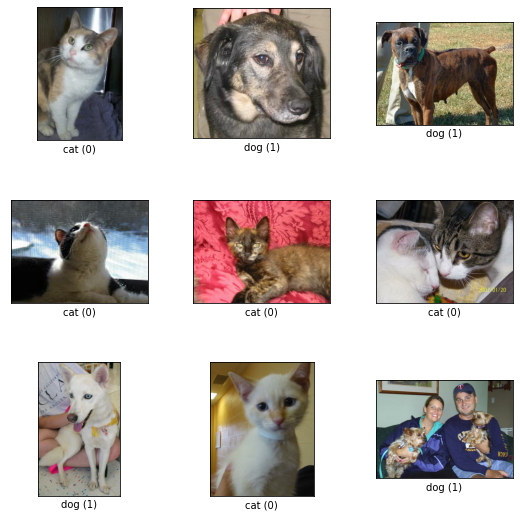

In [18]:
fig = tfds.show_examples(ds_train, ds_info)

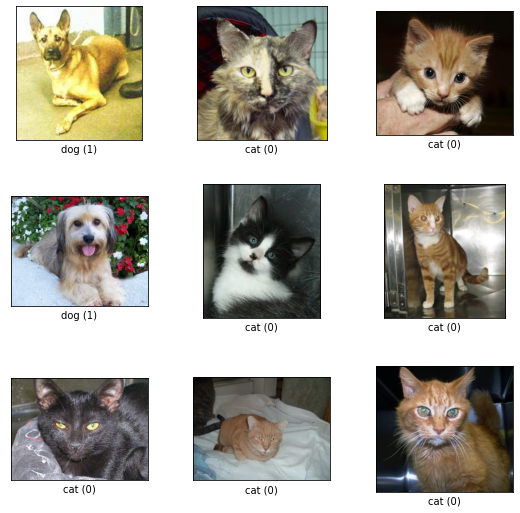

In [19]:
fig = tfds.show_examples(ds_test, ds_info)

## 2) Input Normalization

In [20]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [21]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

# 4. ResNet과 Plain 모델 성능 비교
## 1) 모델 학습

In [22]:
BATCH_SIZE = 16
EPOCH = 10

In [23]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### ResNet-34

In [24]:
resnet_34 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=False, 
                         activation='sigmoid', 
                         name='ResNet_34')

In [25]:
resnet_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 136s 117ms/step - loss: 1.7558 - accuracy: 0.5723 - val_loss: 1.1369 - val_accuracy: 0.5979
Epoch 2/10
1163/1163 [==============================] - 108s 93ms/step - loss: 0.9557 - accuracy: 0.5919 - val_loss: 0.8450 - val_accuracy: 0.5796
Epoch 3/10
1163/1163 [==============================] - 111s 96ms/step - loss: 0.7988 - accuracy: 0.5841 - val_loss: 0.9122 - val_accuracy: 0.5185
Epoch 4/10
1163/1163 [==============================] - 111s 96ms/step - loss: 0.7254 - accuracy: 0.6069 - val_loss: 0.7492 - val_accuracy: 0.5768
Epoch 5/10
1163/1163 [==============================] - 113s 97ms/step - loss: 0.7054 - accuracy: 0.6349 - val_loss: 0.7517 - val_accuracy: 0.5975
Epoch 6/10
1163/1163 [==============================] - 106s 91ms/step - loss: 0.6819 - accuracy: 0.6783 - val_loss: 0.6734 - val_accuracy: 0.6674
Epoch 7/10
1163/1163 [==============================] - 101s 87ms/step - loss: 0.6627 - accuracy: 0.7082 - val_loss: 

In [26]:
df_resnet_34 = pd.DataFrame({
    'train_loss': history_resnet_34.history['loss'],
    'val_acc': history_resnet_34.history['val_accuracy']
    })
df_resnet_34.to_csv('./data/history_resnet_34.csv', index=False)

### ResNet-50

In [26]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), 
                         num_classes=1, 
                         is_50=True,
                         activation='sigmoid')

In [28]:
resnet_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 160s 137ms/step - loss: 4.1694 - accuracy: 0.6204 - val_loss: 2.5462 - val_accuracy: 0.6204
Epoch 2/10
1163/1163 [==============================] - 74s 63ms/step - loss: 1.8274 - accuracy: 0.6954 - val_loss: 1.4558 - val_accuracy: 0.6677
Epoch 3/10
1163/1163 [==============================] - 76s 66ms/step - loss: 1.1693 - accuracy: 0.7376 - val_loss: 2.3798 - val_accuracy: 0.5444
Epoch 4/10
1163/1163 [==============================] - 78s 67ms/step - loss: 0.9142 - accuracy: 0.7615 - val_loss: 1.0869 - val_accuracy: 0.5401
Epoch 5/10
1163/1163 [==============================] - 83s 71ms/step - loss: 0.7954 - accuracy: 0.7829 - val_loss: 1.0631 - val_accuracy: 0.5888
Epoch 6/10
1163/1163 [==============================] - 81s 70ms/step - loss: 0.7423 - accuracy: 0.7918 - val_loss: 0.8500 - val_accuracy: 0.7429
Epoch 7/10
1163/1163 [==============================] - 79s 68ms/step - loss: 0.6547 - accuracy: 0.8214 - val_loss: 0.7904

In [29]:
df_resnet_50 = pd.DataFrame({
    'train_loss': history_resnet_50.history['loss'],
    'val_acc': history_resnet_50.history['val_accuracy']
    })
df_resnet_50.to_csv('./data/history_resnet_50.csv', index=False)

### Plain-34

In [24]:
plain_34 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=False, 
                          activation='sigmoid',
                          name='Plain_34')

In [25]:
plain_34.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 114s 98ms/step - loss: 1.5680 - accuracy: 0.5124 - val_loss: 1.1568 - val_accuracy: 0.5142
Epoch 2/10
1163/1163 [==============================] - 130s 112ms/step - loss: 1.0435 - accuracy: 0.5094 - val_loss: 0.9664 - val_accuracy: 0.4901
Epoch 3/10
1163/1163 [==============================] - 104s 90ms/step - loss: 0.9110 - accuracy: 0.5134 - val_loss: 0.8419 - val_accuracy: 0.4877
Epoch 4/10
1163/1163 [==============================] - 101s 87ms/step - loss: 0.8636 - accuracy: 0.5106 - val_loss: 0.8430 - val_accuracy: 0.5127
Epoch 5/10
1163/1163 [==============================] - 101s 87ms/step - loss: 0.8155 - accuracy: 0.4993 - val_loss: 0.8550 - val_accuracy: 0.5149
Epoch 6/10
1163/1163 [==============================] - 101s 87ms/step - loss: 0.7897 - accuracy: 0.5145 - val_loss: 30.0034 - val_accuracy: 0.4866
Epoch 7/10
1163/1163 [==============================] - 101s 87ms/step - loss: 0.7737 - accuracy: 0.5097 - val_loss:

In [26]:
df_plain_34 = pd.DataFrame({
    'train_loss': history_plain_34.history['loss'],
    'val_acc': history_plain_34.history['val_accuracy']
    })
df_plain_34.to_csv('./data/history_plain_34.csv', index=False)

### Plain-50

In [24]:
plain_50 = build_plainnet(input_shape=(224, 224, 3), 
                          num_classes=1, 
                          is_50=True,
                          activation='sigmoid')

In [25]:
plain_50.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
1163/1163 [==============================] - 201s 173ms/step - loss: 3.2172 - accuracy: 0.5275 - val_loss: 2.9882 - val_accuracy: 0.4847
Epoch 2/10
1163/1163 [==============================] - 173s 149ms/step - loss: 1.8643 - accuracy: 0.5021 - val_loss: 9.3891 - val_accuracy: 0.5188
Epoch 3/10
1163/1163 [==============================] - 149s 128ms/step - loss: 1.4575 - accuracy: 0.5344 - val_loss: 1.5029 - val_accuracy: 0.5306
Epoch 4/10
1163/1163 [==============================] - 149s 128ms/step - loss: 1.2896 - accuracy: 0.5182 - val_loss: 1.1848 - val_accuracy: 0.4866
Epoch 5/10
1163/1163 [==============================] - 149s 128ms/step - loss: 1.0830 - accuracy: 0.5270 - val_loss: 1.0327 - val_accuracy: 0.4836
Epoch 6/10
1163/1163 [==============================] - 149s 128ms/step - loss: 1.0339 - accuracy: 0.4991 - val_loss: 0.9808 - val_accuracy: 0.4789
Epoch 7/10
1163/1163 [==============================] - 148s 127ms/step - loss: 0.9168 - accuracy: 0.5129 - val_

In [26]:
df_plain_50 = pd.DataFrame({
    'train_loss': history_plain_50.history['loss'],
    'val_acc': history_plain_50.history['val_accuracy']
    })
df_plain_50.to_csv('./data/history_plain_50.csv', index=False)

## 2) 결과 비교

In [12]:
history_resnet_34 = pd.read_csv('./data/history_resnet_34.csv')
history_resnet_50 = pd.read_csv('./data/history_resnet_50.csv')
history_plain_34 = pd.read_csv('./data/history_plain_34.csv')
history_plain_50 = pd.read_csv('./data/history_plain_50.csv')

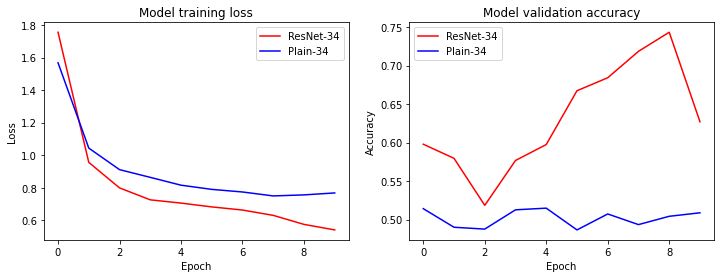

In [13]:
# ResNet-34 vs Plain-34
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'Plain-34'], loc='upper left')
plt.show()

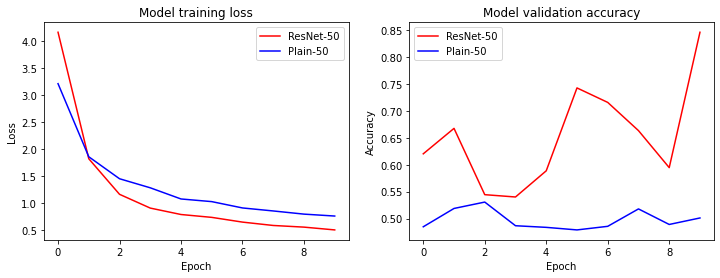

In [14]:
# ResNet-50 vs Plain-50
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_50['train_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_50['val_acc'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-50', 'Plain-50'], loc='upper left')
plt.show()

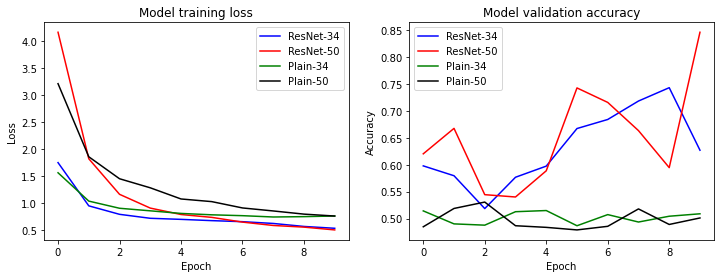

In [15]:
# 전체 비교
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_resnet_34['train_loss'], 'b')
plt.plot(history_resnet_50['train_loss'], 'r')
plt.plot(history_plain_34['train_loss'], 'g')
plt.plot(history_plain_50['train_loss'], 'k')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34['val_acc'], 'b')
plt.plot(history_resnet_50['val_acc'], 'r')
plt.plot(history_plain_34['val_acc'], 'g')
plt.plot(history_plain_50['val_acc'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet-34', 'ResNet-50', 'Plain-34', 'Plain-50'], loc='upper left')
plt.show()

In [23]:
# validation accuracy 비교표
accuracy = {
    'Plain': [round(history_plain_34['val_acc'].mean(), 4),
              round(history_plain_50['val_acc'].mean(), 4)],
    'ResNet': [round(history_resnet_34['val_acc'].mean(), 4), 
               round(history_resnet_50['val_acc'].mean(), 4)]
}

df_acc = pd.DataFrame(accuracy, index=['34 layers', '50 layers'])
df_acc

,Plain,ResNet
34 layers,0.5020,0.6311
50 layers,0.4977,0.6525


***
**ResNet-34 vs Plain-34, ResNet-50 vs Plain-50 성능 비교**
- Training Loss
    - 초기 loss는 ResNet이 Plain 모델보다 높았지만, epoch 2부터 값이 큰 폭으로 감소하여 ResNet이 더 안정적으로 수렴하는 양상을 보였다.
- Validation Accuracy
    - ResNet은 학습이 진행될수록 정확도가 향상되는 추세를 보였지만, Plain 모델은 거의 변화가 없었다.
    - 위의 표를 보면, Plain-34보다 Plain-50의 정확도가 더 낮아 Plain 모델은 레이어가 깊어지면 학습이 제대로 이루어지지 않는다는 것을 알 수 있었다. 반면 ResNet은 레이어가 더 깊은 ResNet-50의 정확도가 더 높게 나타나 층이 많아져도 학습이 잘 이루어짐을 알 수 있었다.
- 시간 관계상 10 epoch만 학습시켰지만, epoch을 늘려 충분히 학습시킨다면 차이가 더 뚜렷하게 나타날 것이다.
***
**학습 관련 이슈**
- `cats_vs_dogs` 데이터셋에 맞게 `activation='sigmoid'`로 변경해주었다. 처음에 이 부분을 간과하고 softmax를 그대로 사용했더니 학습이 제대로 이루어지지 않는 문제가 있었는데 sigmoid를 사용하니 해결되었다.
- 메모리 부족 문제가 발생하여 `BATCH_SIZE=16`으로 줄이고, 모델 하나를 학습시킨 뒤 커널을 재시작하고 다음 모델을 학습시키는 방법을 반복했다. 주요 성능 지표는 데이터프레임으로 만들어 csv 파일로 저장해두었다가 불러와서 시각화에 활용했다.